In [1]:
# from gradCam.VAE_grad_cam import *
from gradCam.vis_util import *
from gradCam.LinearVAE_grad_cam import *

import sys
sys.path.append("../Reconstruction/")
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [2]:
import os
import shutil
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.distributed as dist
import torch.optim
# import torch.utils.data
import torch.utils.data as data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data.sampler import SubsetRandomSampler
# import models
# import utils.flops as flops

# import Reconstruction.models as models



import argparse, os, pickle, glob, cv2
import matplotlib.pyplot as plt
import numpy as np

from utils.loss_function import select_loss_function
from utils.get_cdim import update_code_dim

from data.dataset import StanfordDog
from Solver import LinearSolver, ConvSolver

from models.simpleAE import simpleAE
from models.LinearVAE import LinearVAE
from models.ConvVAE import ConvVAE

from torchvision.datasets import MNIST
from scipy.stats import norm

from copy import deepcopy

In [3]:
picReslu = 96
zdim = 16
model = LinearVAE(z_dim=zdim, hidden=512, num_channels=32*32) # MNIST
model = model.cuda()

checkpoints = glob.glob(pathname = '../Reconstruction/minst_checkpoints/LinearVAE_%d.pth'%zdim)


if len(checkpoints) != 0:
    model.load(path=checkpoints[0])
    print("loaded:", checkpoints[0])
    

loaded: ../Reconstruction/minst_checkpoints/LinearVAE_16.pth


In [4]:
def preprocess(image_path):
    raw_image = cv2.imread(image_path)
    raw_image = cv2.resize(raw_image, (picReslu,) * 2) # this 32 is correspondent to the 32 in c_dim
    image = transforms.Compose(
        [
            transforms.ToTensor(),
        ]
    )(raw_image[..., ::-1].copy())
    return image, raw_image

In [5]:
images = []
raw_images = []
print("Images:")
# #####IMAGES FOR DOG #######
# image_paths = ["../Reconstruction/data/Images/n02090622-borzoi/n02090622_3615.jpg"]#,"cat_dog.png"]
# image_paths = ["../Reconstruction/data/Images/n02090622-borzoi/n02090622_3615.jpg"]#,"cat_dog.png"]

# for i, image_path in enumerate(image_paths):
#     print("\t#{}: {}".format(i, image_path))
#     image, raw_image = preprocess(image_path)
#     images.append(image)
#     raw_images.append(raw_image)

# images = torch.stack(images).cuda()

#### IMAGES FOR MNIST #####
train_loader = torch.utils.data.DataLoader(dataset=MNIST('../Reconstruction/data/{0}'.format("mnist"), train=True,download=True ,transform=transforms.Compose([transforms.Resize(32), transforms.ToTensor()])), batch_size=1, shuffle=True)
images, _ = next(iter(train_loader))
raw_images = images

Images:


###P###: (5, 13)
torch.Size([1, 1, 32, 32])
raw_shape: (1, 1, 32, 32)
outshape: (1, 1, 32, 32)
torch.Size([1, 1, 32, 32])
(32, 32, 1)


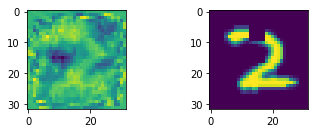

###P###: (15, 10)
torch.Size([1, 1, 32, 32])
raw_shape: (1, 1, 32, 32)
outshape: (1, 1, 32, 32)
torch.Size([1, 1, 32, 32])
(32, 32, 1)


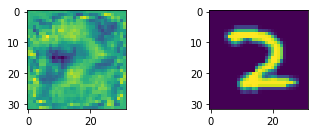

###P###: (7, 15)
torch.Size([1, 1, 32, 32])
raw_shape: (1, 1, 32, 32)
outshape: (1, 1, 32, 32)
torch.Size([1, 1, 32, 32])
(32, 32, 1)


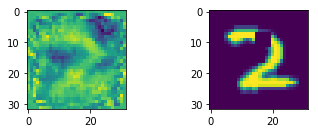

###P###: (20, 10)
torch.Size([1, 1, 32, 32])
raw_shape: (1, 1, 32, 32)
outshape: (1, 1, 32, 32)
torch.Size([1, 1, 32, 32])
(32, 32, 1)


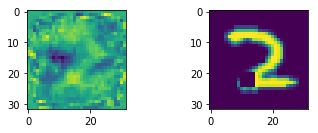

###P###: (10, 20)
torch.Size([1, 1, 32, 32])
raw_shape: (1, 1, 32, 32)
outshape: (1, 1, 32, 32)
torch.Size([1, 1, 32, 32])
(32, 32, 1)


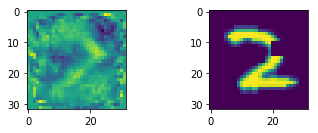

In [6]:
def area_grad_cam(images, raw_images, pos, size = (6,6)):
    
    bp = GuidedBackPropagation(model=model)
    print(images.shape)
    # out = bp.forward(images)
    raws = np.array(raw_images)
    print("raw_shape:",raws.shape )
#     raws = raws.transpose(0,3,1,2) # comment out this in MNIST
    
#     images = torch.Tensor(raws).cuda()
    images = images.view(images.shape[0], 1, -1)
    images = images.cuda()
#     print("images shape:",images.shape)

    out = bp.forward(images)

    out = out.cpu().detach().numpy()
    print("outshape:",out.shape)

    bp.backward(pos = pos, size = size)
    t_raw_images = deepcopy(raw_images)
    
    t_raw_images[0][:,pos[0][0]:pos[0][0]+size[0],pos[0][1]:pos[0][1]+size[1] ] = 0 # MNIST
#     t_raw_images[0][pos[0][0]:pos[0][0]+size[0],pos[0][1]:pos[0][1]+size[1],: ] = 0 # DOG

    gradients = bp.generate()
    gradient = gradients[0]
    gradient = gradient.reshape(1,32,32) # MNIST hard coded not good
    gradient = gradient.cpu().numpy().transpose(1, 2, 0)
    gradient -= gradient.min()
    gradient /= gradient.max()
    gradient *= 255.0
    print(gradient.shape)
    gradient = np.uint8(gradient)
    gradient = gradient.reshape(32,32) # add this in MNIST
#     gradient = cv2.cvtColor(gradient, cv2.COLOR_BGR2GRAY)



#     gcam = GradCAM(model=model,candidate_layers=["Encoder.main.7"])
#     _ = gcam.forward(images)
#     gcam.backward(pos,size)
#     regions = gcam.generate(target_layer="Encoder.main.7")


    plt.subplot(221)
    plt.imshow(gradient)#,"gray")
    plt.subplot(222)
    plt.imshow(t_raw_images[0][0,:,:]) #MNIST
#     plt.imshow(t_raw_images[0]) #dog

#     plt.subplot(223)
#     plt.imshow(out[0][0,:,:])
# #     plt.imshow(out[0].transpose(1,2,0))

#     plt.subplot(224)
#     print(images.shape)
#     img = images.cpu().detach().numpy()
# #     plt.imshow(img[0].transpose(1,2,0))
#     plt.imshow(img[0].reshape(32,32))

    plt.show()
# area_grad_cam(images, raw_images, pos=np.array([[5,13]]))
# for p in [(5,13),(40,10),(15,45),(60,60),(10,70)]:
for p in [(5,13),(15,10),(7,15),(20,10),(10,20)]:
    print("###P###:",p)
    area_grad_cam(images, raw_images,pos = np.array([[*p]]), size = (5,5))